<h1><center>Proyecto 2🤖🪙</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Pablo Badilla y Ignacio Meza D.
- Auxiliar: Sebastián Tinoco
- Ayudante: Felipe Arias y Diego Cortez

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Lennin Chamorro
- Nombre de alumno 2: Martín Reyes Oviedo


### **Link de repositorio de GitHub:** `http://....`

## 1. Introducción

El objetivo de la realización de este proyecto consiste en aplicar todos los conocimientos aprendidos en la segunda mitad del curso de una forma integral y aplicada a casos del mundo laboral, por lo que el cuerpo docente brindó un dataset que tienen distintos registros de clientes de bancos la idea es clasificar a los clientes en dos categorías: "bajo riesgo" (clientes confiables que tienen una alta probabilidad de pagar sus préstamos) y "alto riesgo" (clientes que tienen una probabilidad más baja de pagar sus préstamos). Esta clasificación ayudara a **Guiturra** a prestar de manera más informda a sus clientes, mitigando así el riesgo de impagos y pérdidas financieras.

El dataset entregado es ``dataset.pq`` un dataset con las siguientes columnas:

- `customer_id`: Un identificador único para cada cliente en el dataset.
- `age`: La edad del cliente.
- `occupation`: La ocupación o profesión del cliente.
- `annual_income`: El ingreso anual del cliente.
- `monthly_inhand_salary`: El salario mensual que el cliente recibe después de las deducciones.
- `num_bank_accounts`: Número de cuentas bancarias que el cliente posee.
- `num_credit_card`: Número de tarjetas de crédito que el cliente tiene.
- `interest_rate`: Tasa de interés aplicada a los préstamos o tarjetas de crédito del cliente.
- `num_of_loan`: Número de préstamos que el cliente tiene.
- `delay_from_due_date`: La cantidad de días de retraso en los pagos con respecto a la fecha de vencimiento.
- `num_of_delayed_payment`: Número de pagos que el cliente ha retrasado.
- `changed_credit_limit`: Indica si el límite de crédito del cliente ha sido modificado recientemente.
- `num_credit_inquiries`: Número de consultas de crédito realizadas en el historial del cliente.
- `outstanding_debt`: Deuda pendiente o saldo pendiente del cliente.
- `credit_utilization_ratio`: Proporción del límite de crédito que el cliente está utilizando actualmente.
- `credit_history_age`: Antigüedad del historial de crédito del cliente.
- `payment_of_min_amount`: Indica si el cliente ha realizado el pago mínimo requerido en sus préstamos o tarjetas de crédito.
- `total_emi_per_month`: Total de cuotas de préstamos o créditos que el cliente paga mensualmente.
- `amount_invested_monthly`: Cantidad de dinero que el cliente invierte mensualmente.
- `payment_behaviour`: Comportamiento de pago del cliente, como puntual, retrasado, etc.
- `monthly_balance`: Saldo mensual de las cuentas bancarias del cliente.
- `credit_score`: Puntuación de crédito del cliente, que es una medida de su solvencia crediticia.


Para este tipo de clasificaciones el accuracy no es una métrica confiable puesto que naturalmente los clientes riesgosos son desbalanceados con respecto al total de la población, por lo que se decidirá optimizar los modelos maximizando el recall del label 1 ya que según su fórmula:

<center>Recall = TP / (TP + FN)</center>

con TP los verdaderos positivos (label 1, predichos como 1) y FN los falsos negativos (label 1, predichos como 0) se busca que esta métrica sea lo más cercana a 1, puesto que de ser así se estarían identificando todos los casos riesgosos así minimizando las pérdidas del banco ya que no se estaría haciendo prestamos a nadie que sea riesgoso.

El modelo con el que se resolvera el problema es `LigthGBMClassifier` El cual  es un modelo de aprendizaje automático basado en el algoritmo de refuerzo (boosting)que combina varios modelos más simples, llamados "modelos débiles", para crear un modelo más poderoso y preciso.

En cuanto a las transformaciones se realizo un analisis exploratorio inicial con el que se definieron filtros sobre las columnas para eliminar los valores outliers, luego se analizaron las distribuciones de los datos restantes para agrupar las columnas según como se comportan sus curvas en histogramas y para el caso de las categoricas se separaron en varias columnas. El detalle del analisis se puede ver en la sección de preprocesamiento.

Se decidio abordar el problema desde la mirada de un banco en situación de crisis ante el problema de impago de sus clientes, para esto nos enfocamos en identificar a aquellos clientes con alto riesgo por sobre todos los demás. Por esto decidimos evaluar usando recall sobre la categoría menos común. El modelo fue capaz de asignar correctamente el riesgo de aproximadamente el 70% de los clientes riesgosos, puediendo mejorarse aún si se toma en consideración los resultados del analisis de interpretabilidad, relajando los filtros pero descartando aquellas columnas que no fueron de importancia en la predicción.


In [ ]:
import joblib as jb
import lightgbm
import numpy as np
import pandas as pd
import scipy as sp
import xgboost as xgb
import plotly

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# Pre-procesamiento
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

import optuna
from imblearn.over_sampling import RandomOverSampler
from pycaret.classification import *
import shap

## 2.Carga de datos

In [ ]:
df = pd.read_parquet("C:/Users/marti/Desktop/Universidad/IX_Semestre/LPC/Proyecto_2/dataset.pq")

In [ ]:
df.head()

customer_id   age    occupation  annual_income  monthly_inhand_salary  \
0   CUS_0xd40  23.0     Scientist       19114.12            1824.843333   
1  CUS_0x21b1  28.0       Teacher       34847.84            3037.986667   
2  CUS_0x2dbc  34.0      Engineer      143162.64           12187.220000   
3  CUS_0xb891  55.0  Entrepreneur       30689.89            2612.490833   
4  CUS_0x1cdb  21.0     Developer       35547.71            2853.309167   

   num_bank_accounts  num_credit_card  interest_rate  num_of_loan  \
0                  3                4              3          4.0   
1                  2                4              6          1.0   
2                  1                5              8          3.0   
3                  2                5              4       -100.0   
4                  7                5              5       -100.0   

   delay_from_due_date  ...  num_credit_inquiries  outstanding_debt  \
0                    3  ...                   4.0            809.98   
1                    3  ...                   2.0            605.03   
2                    8  ...                   3.0           1303.01   
3                    4  ...                   4.0            632.46   
4                    1  ...                   4.0            943.86   

   credit_utilization_ratio  credit_history_age  payment_of_min_amount  \
0                 23.933795                 NaN                     No   
1                 32.933856                27.0                     No   
2                 38.374753                18.0                     No   
3                 27.332515                17.0                     No   
4                 25.862922                31.0                    Yes   

   total_emi_per_month amount_invested_monthly  \
0            49.574949               24.785217   
1            18.816215              218.904344   
2           246.992319            10000.000000   
3            16.415452              125.617251   
4             0.000000              181.330901   

                  payment_behaviour  monthly_balance credit_score  
0  High_spent_Medium_value_payments       358.124168            0  
1    Low_spent_Small_value_payments       356.078109            0  
2   High_spent_Small_value_payments       895.494583            0  
3   High_spent_Small_value_payments       379.216381            0  
4   High_spent_Small_value_payments       364.000016            0  

[5 rows x 22 columns]

## 3.Preparación de Datos

Para esta seccion se realizó una limpieza exahustiva de datos, eliminando todo tipo de outlayers y valores nulos, con respeccto a los valores nulos solo se dejaro y reemplazaron con 0 en los casos que se consideraron pertinentes como monthly_inhand_salary, changed_credit_limit, monthly_balance, que se interpretó el valor nulo como 0. También se añadieron las columnas segmento_edad, que consiste en la segmentación de clientes por edad con las categorias menor de edad, adulto joven, adulto y adulto mayor, prop_deuda_sueldo_anual que consiste en una proporcion entre la deuda del cliente y sus ingresos anuales y finalmente se agregó también prop_emi_sueldo que es una proporcion entre el EMI del mes y su sueldo, estas últimas siendo métricas interesantes a estudiar, esperando que tengan impoacto en la predicción.

In [ ]:
rangos = [0, 18, 30, 60, float('inf')]

etiquetas = ['menor de edad', 'adulto joven', 'adulto', 'adulto mayor']

df['segmento_edad'] = pd.cut(df['age'], bins=rangos, labels=etiquetas, right=False)
df['prop_deuda_sueldo_anual'] = df['outstanding_debt'] / df['annual_income']
df['prop_emi_sueldo'] = df['total_emi_per_month']/df['monthly_inhand_salary']

In [ ]:
condiciones = df[
        (df['age'] < 0) | (df['age'] > 150) |
        (df['num_bank_accounts'] < 0) |
        (df['num_credit_card'] > 20) |
        (df['num_bank_accounts'] > 20) |
        (df['interest_rate'] > 500) |
        (df['num_of_loan'] > 10) |
        (df['num_of_loan'] < 0) |
        (df['num_of_delayed_payment'].isna()) |
        (df['monthly_inhand_salary'].isna()) |
        (df['num_of_delayed_payment'] < 0) |
        (df['num_of_delayed_payment'] > 30) |
        (df['num_credit_inquiries'].isna()) |
        (df['num_credit_inquiries'] > 20) |
        (df['total_emi_per_month'] > 10000) |
        (df['credit_history_age'].isna()) |
        (df['amount_invested_monthly'].isna()) |
        (df['amount_invested_monthly'] > 2000) |
        (df['monthly_balance'] < 0) |
        (df['payment_behaviour']=='!@9#%8') |
        (df['payment_of_min_amount']=='NM') |
        (df['prop_emi_sueldo'] > 1)
]

In [ ]:
df = df.drop(condiciones.index)
df['monthly_inhand_salary'] = df['monthly_inhand_salary'].fillna(0)
df['changed_credit_limit'] = df['changed_credit_limit'].fillna(0)
df['monthly_balance'] = df['monthly_balance'].fillna(0)

Seguido a este filtrado y añadicion de columnas, se procedio a realizar un análisis eda para ver las mejores transformaciones para normalizar las columnas del dataset resultante, obteniendose finalmente el ``ColumnTransformer`` que se va a útilizar para el proyecto.

In [ ]:
# from ydata_profiling import ProfileReport

# profile = ProfileReport(df, title="EDA")
# profile.to_file("C:/Users/marti/Desktop/Universidad/IX_Semestre/LPC/Proyecto_2/eda_proy2.html")

In [ ]:
df.head()

customer_id   age     occupation  annual_income  monthly_inhand_salary  \
1   CUS_0x21b1  28.0        Teacher       34847.84            3037.986667   
6   CUS_0x284a  34.0         Lawyer      131313.40           10469.207759   
7   CUS_0x5407  30.0  Media_Manager       34081.38            2611.115000   
8   CUS_0x4157  24.0         Doctor      114838.41            9843.867500   
12  CUS_0x3e45  36.0   Entrepreneur       54392.16            4766.680000   

    num_bank_accounts  num_credit_card  interest_rate  num_of_loan  \
1                   2                4              6          1.0   
6                   0                1              8          2.0   
7                   8                7             15          3.0   
8                   2                5              7          3.0   
12                  6                4             14          3.0   

    delay_from_due_date  ...  credit_history_age  payment_of_min_amount  \
1                     3  ...                27.0                     No   
6                     0  ...                31.0                     No   
7                    30  ...                15.0                    Yes   
8                    11  ...                21.0                     No   
12                   10  ...                27.0                    Yes   

    total_emi_per_month  amount_invested_monthly  \
1             18.816215               218.904344   
6            911.220179               870.522382   
7             70.478333                29.326364   
8            226.892792               254.571767   
12           124.392082               495.117898   

                   payment_behaviour  monthly_balance credit_score  \
1     Low_spent_Small_value_payments       356.078109            0   
6    Low_spent_Medium_value_payments       396.111346            0   
7   High_spent_Medium_value_payments       411.306804            1   
8    High_spent_Large_value_payments       742.922191            0   
12    Low_spent_Small_value_payments       147.158020            0   

    segmento_edad  prop_deuda_sueldo_anual prop_emi_sueldo  
1    adulto joven                 0.017362        0.006194  
6          adulto                 0.002682        0.087038  
7          adulto                 0.050003        0.026992  
8    adulto joven                 0.011997        0.023049  
12         adulto                 0.003295        0.026096  

[5 rows x 25 columns]

In [ ]:
minmax = [
    'age',
    'num_bank_accounts',
    'num_credit_card',
    'num_of_loan',
    'delay_from_due_date',
    'num_of_delayed_payment',
    'changed_credit_limit',
    'num_credit_inquiries',
    'credit_utilization_ratio',
    'credit_history_age'
]

log = [
    'annual_income',
    'monthly_inhand_salary',
    'interest_rate',
    'outstanding_debt',
    'total_emi_per_month',
    'amount_invested_monthly',
    'monthly_balance',
    'prop_deuda_sueldo_anual',
    'prop_emi_sueldo'
]
sino = 'payment_of_min_amount'
sinord = ['No','Yes']

ordinal = 'segmento_edad'


onehot = [
    'occupation',
    'payment_behaviour'
]

In [ ]:
def log_transform(x):
    return np.log(x + 2)

In [ ]:
transformer = ColumnTransformer([
    ('min_max_scaler', MinMaxScaler(), minmax),
    ('one_hot_encoder', OneHotEncoder(sparse=False), onehot),
    ('caregorical', OrdinalEncoder(categories = [sinord, etiquetas]), [sino, ordinal]),
    ('log', FunctionTransformer(log_transform), log)
], remainder='passthrough').set_output(transform='pandas')

#se creo un transformador exclusivo para KNeighborsClassifier porque necesita de entrada un np.array
transformer_kneig = ColumnTransformer([
    ('min_max_scaler', MinMaxScaler(), minmax),
    ('one_hot_encoder', OneHotEncoder(sparse=False), onehot),
    ('caregorical', OrdinalEncoder(categories = [sinord, etiquetas]), [sino, ordinal]),
    ('log', FunctionTransformer(log_transform), log)
], remainder='passthrough')


In [ ]:
df_filt = transformer.fit_transform(df)

## 4. Baseline

Seguido a esto se separa el dataset en entrenamiento y test con unos respectivos 80 y 20 porciento del dataset inicial y se procede a entrenar la siguiente lista de modelos para luego comparar sus desempeños.

- `Dummy` con estrategia estratificada.
- `LogisticRegression`.
- `KNeighborsClassifier`.
- `DecisionTreeClassifier`
- `SVC`
- `RandomForestClassifier`
- `LightGBMClassifier` (del paquete `lightgbm`)
- `XGBClassifier` (del paquete `xgboost`).

estos modelos despues del entrenamiento se les obtiene su ``classification_report`` y se evalúan sobre la métrica de recall

In [ ]:
X = df.drop(columns=['customer_id', 'credit_score'])
y = df['credit_score']

In [ ]:
modelos = [
    ('DummyClassifier', DummyClassifier(strategy='stratified', random_state=23)),
    ('LogisticRegression', LogisticRegression(max_iter=1000, random_state=23)),
    ('KNeighborsClassifier', KNeighborsClassifier()),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=23)),
    ('SVC', SVC(random_state=23)),
    ('RandomForestClassifier', RandomForestClassifier(random_state=23)),
    ('LightGBMClassifier', LGBMClassifier(random_state=23)),
    ('XGBClassifier', XGBClassifier())
]
results_recall = {}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

In [ ]:
for nombre, modelo in modelos:
    if nombre == 'KNeighborsClassifier':
        pipe = Pipeline([
        ('transformer', transformer_kneig),
        ('classif', modelo)
        ])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        report = classification_report(y_test, y_pred)
        print('-------------------------------------------------------------')
        print(report)
        results_recall['recall_' + nombre] = recall_score(y_test, y_pred)
        continue
    pipe = Pipeline([
        ('transformer', transformer),
        ('classif', modelo)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    report = classification_report(y_test, y_pred)
    print('-------------------------------------------------------------')
    print(nombre)
    print(report)
    results_recall['recall_' + nombre] = recall_score(y_test, y_pred)


-------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       795
           1       0.24      0.24      0.24       296

    accuracy                           0.59      1091
   macro avg       0.48      0.48      0.48      1091
weighted avg       0.59      0.59      0.59      1091

-------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       795
           1       0.66      0.46      0.54       296

    accuracy                           0.79      1091
   macro avg       0.74      0.69      0.70      1091
weighted avg       0.78      0.79      0.78      1091

-------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       795
           1       0.51      0.46      0.48       2

In [ ]:
claves = pd.Series(list(results_recall.keys()), name='Modelo')
valores = pd.Series(list(results_recall.values()), name='Recall')

resultados = pd.concat([claves, valores], axis=1)
resultados = pd.DataFrame(resultados, columns=['Modelo', 'Recall']).sort_values('Recall', ascending=False)

In [ ]:
resultados

Modelo    Recall
6      recall_LightGBMClassifier  0.527027
5  recall_RandomForestClassifier  0.503378
7           recall_XGBClassifier  0.496622
2    recall_KNeighborsClassifier  0.462838
3  recall_DecisionTreeClassifier  0.462838
1      recall_LogisticRegression  0.459459
0         recall_DummyClassifier  0.236486
4                     recall_SVC  0.000000

Viendo los resultados casi todos los clasificadores resultan tener mejores métricas que el ``DummyClassifier``, a excepción del ``SVC``.

Se puede ver también que el mejor clasificador entrenado corresponde al de tipo ``LightGBMClassifier``, este resultado se puede deber a que este tipo de modelos es un ensamblaje de varios modelos menos robustos que se encargan de colaborar mejorando los resultados finales de la salida, al igual que ``XGBoost``. Este tipo de clasificadores son utiles para grandes cantidades de features de distintas naturalezas como lo es en este caso por lo que los algoritmos de boosting pudieron tomar la ventaja en este problema. Sin embargo, en este caso es que ``LightGBMClassifier`` resultó adaptarse de mejor manera a la gran cantidad de datos que tenía el dataset a diferencia de ``XGBoost`` que logró un tercer lugar en la tabla.

De los resultados se puede ver que  ninguno obtiene un valor en la métrica de recall muy robusto, por lo que se escogen los dos modelos que tuvieron mejor desempeño, ``LightGBMClassifier`` y ``RandomForestClassifier`` y se realizará un entrenamiento más exahustivo a estos.

En términos de tiempo de entrenamiento, si bien ``DummyClassifier`` y ``SVC`` son conocidos por tener tiempos de entrenamientos muy cortos, se pudo ver que en estos no se obtivieron resultados para nada satisfactorios, por lo que la elección de ``LightGBMClassifier`` y ``RandomForestClassifier`` si bien demoran más, tiene una mayor probabilidad de obtener mejores resultados, además que en comparación con el resto de clasificadores y considerando el tamaño del dataset de entrenamiento, es posible que la diferencia de tiempo de entrenamiento no sea significativa.

## 5. Optimización del Modelo

In [ ]:
pipe_lgbmc = Pipeline([
    ('transformer', transformer),
    ('classifier', LGBMClassifier(random_state=23))
])
pipe_rf = Pipeline([
    ('transformer', transformer),
    ('classifier', RandomForestClassifier(random_state=23))
])

Primero se intentó realizar una optimizacion de hiperparámetros mediante ``GridSearchCV`` para ambos clasificadores obteniendo los siguientes resultados:

In [ ]:
# Definir los hiperparámetros y sus valores posibles para RandomForestClassifier
param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
}

# Definir los hiperparámetros y sus valores posibles para LGBMClassifier
param_grid_lgbm = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [-1, 10, 20],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__min_child_samples': [5, 10, 20],
}

# Realizar GridSearchCV para RandomForestClassifier
grid_search_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='recall', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Realizar GridSearchCV para LGBMClassifier
grid_search_lgbm = GridSearchCV(pipe_lgbmc, param_grid_lgbm, cv=5, scoring='recall', n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# Mejor clasificador y sus hiperparámetros para RandomForestClassifier
best_rf = grid_search_rf.best_estimator_
best_params_rf = grid_search_rf.best_params_

# Mejor clasificador y sus hiperparámetros para LGBMClassifier
best_lgbm = grid_search_lgbm.best_estimator_
best_params_lgbm = grid_search_lgbm.best_params_

# Imprimir los resultados para RandomForestClassifier
print("Mejores hiperparámetros para RandomForestClassifier:", best_params_rf)
print("Recall del mejor clasificador (RandomForestClassifier) en el conjunto de prueba:",
      best_rf.score(X_test, y_test))

# Imprimir los resultados para LGBMClassifier
print("Mejores hiperparámetros para LGBMClassifier:", best_params_lgbm)
print("Recall del mejor clasificador (LGBMClassifier) en el conjunto de prueba:",
      best_lgbm.score(X_test, y_test))


[LightGBM] [Info] Number of positive: 1293, number of negative: 3069
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2867
[LightGBM] [Info] Number of data points in the train set: 4362, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.296424 -> initscore=-0.864387
[LightGBM] [Info] Start training from score -0.864387
Mejores hiperparámetros para RandomForestClassifier: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Recall del mejor clasificador (RandomForestClassifier) en el conjunto de prueba: 0.7983501374885427
Mejores hiperparámetros para LGBMClassifier: {'classifier__learning_rate': 0.1, 'classifier__max_depth': -1, 'classifier__min_child_samples': 5, 'classifier__n_estimators': 50}
Recall del mejor clasificador (LGBMClassif

In [ ]:
pipe_final_gridsearch = Pipeline([
    ('transformer', transformer),
    ('classifier', LGBMClassifier(learning_rate = 0.1, max_depth = -1, min_child_samples = 5, n_estimators = 50, random_state=23))
])

pipe_final_gridsearch.fit(X_train,y_train)
y_pred_gscv = pipe_final_gridsearch.predict(X_test)
report = classification_report(y_pred_gscv, y_test)
print(report)

[LightGBM] [Info] Number of positive: 1293, number of negative: 3069
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2867
[LightGBM] [Info] Number of data points in the train set: 4362, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.296424 -> initscore=-0.864387
[LightGBM] [Info] Start training from score -0.864387
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       849
           1       0.54      0.67      0.60       242

    accuracy                           0.80      1091
   macro avg       0.72      0.75      0.73      1091
weighted avg       0.82      0.80      0.81      1091



De aqui se puede ver que el recal de 0,80 obtenido por la optimizacion corresponde al promedio ponderado por la proporcion de cada una de las etiquetas, sin embargo, el recall que se desea optimizar en este proyecto correspone al recal respecto al label 1, que es de 0,67, valor bastante mayor a los mejores obtenido en las secciones anteriores, sin embargo es aún mejorable ya que a nivel de industria no parece muy aceptable el valor de 0,67. Para ello se intentará mejorar la optimizacion de huperparámetros mediante la librería optuna, ejecutando el código a continuación.

In [ ]:
# Función de objetivo para optimización de hiperparámetros con RandomForestClassifier
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_categorical('max_depth', [None, 10, 20]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
    }
    pipe_rf = Pipeline([
        ('transformer', transformer),
        ('classifier', RandomForestClassifier(**params))
    ], memory='.'
    )
    pipe_rf.fit(X_train, y_train)
    y_pred_rf = pipe_rf.predict(X_test)

    return recall_score(y_test, y_pred_rf)

# Función de objetivo para optimización de hiperparámetros con LGBMClassifier
def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_categorical('max_depth', [-1, 10, 20]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 20),
    }
    pipe_lgbmc = Pipeline([
    ('transformer', transformer),
    ('classifier', LGBMClassifier(**params))
    ], memory='.'
    )

    pipe_lgbmc.fit(X_train, y_train)
    y_pred_lgbmc = pipe_lgbmc.predict(X_test)

    return recall_score(y_pred_lgbmc, y_test)

optuna.logging.set_verbosity(optuna.logging.WARNING)
# Realizar la búsqueda de hiperparámetros con Optuna
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=500)

optuna.logging.set_verbosity(optuna.logging.WARNING)
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=500)

# Mejores hiperparámetros y puntajes
best_params_rf_optuna = study_rf.best_params
best_score_rf = study_rf.best_value

best_params_lgbm_optuna = study_lgbm.best_params
best_score_lgbm = study_lgbm.best_value

# Imprimir los resultados para RandomForestClassifier
print("Mejores hiperparámetros para RandomForestClassifier:", best_params_rf_optuna)
print("Recall del mejor clasificador (RandomForestClassifier) en el conjunto de prueba:",
      best_score_rf)

# Imprimir los resultados para LGBMClassifier
print("Mejores hiperparámetros para LGBMClassifier:", best_params_lgbm_optuna)
print("Recall del mejor clasificador (LGBMClassifier) en el conjunto de prueba:",
      best_score_lgbm)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1293, number of negative: 3069
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2867
[LightGBM] [Info] Number of data points in the train set: 4362, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.296424 -> initscore=-0.864387
[LightGBM] [Info] Start training from score -0.864387
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (nu

De los resultados obtenidos se puede ver que esta vez si se optimizó sobre el recall de la label 1, por lo que la optimizacion para el ``LGBMClassifier`` con los hiperparámetros encontrados logró mejorar el recall del modelo a un 0,70, valor que aun es perfectible.

In [ ]:
pipe_final_shap = Pipeline([
    ('transformer', transformer),
    ('classifier', LGBMClassifier(learning_rate = 0.012544315884846483, max_depth = 10, min_child_samples = 18, n_estimators = 73, random_state=23))
])

In [ ]:
pipe_final_shap.fit(X_train,y_train)
y_pred_f = pipe_final_shap.predict(X_test)
report = classification_report(y_pred_f, y_test)
print(report)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1293, number of negative: 3069
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2867
[LightGBM] [Info] Number of data points in the train set: 4362, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.296424 -> initscore=-0.864387
[LightGBM] [Info] Start training from score -0.864387
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
              precision    recall  f1-score   suppor

Seguido a esto se realizaron unos mapas de optuna donde se puede visualizar los recorridos realizados por nos hiperparámetros y las distintas combinaciones de estos, reflejandose como un mapa de calor con el recall del modelo siendo los colores más fuertes los que significan un mayor recall, pudiendose así explorar de una manera más visual las zonas donde se combinan ciertos hiperparámetros para optimizar el recall del modelo.

### Caso Random Forest

In [ ]:
optuna.visualization.plot_contour(study_rf)

### Caso Random LGBM

In [ ]:
optuna.visualization.plot_contour(study_lgbm)

Otro tipo de herramientas que pueden ser útil para este tipo de modelos desbalanceados es implementar métodos como el oversampling que consiste en incrementar la cantidad de muestras hasta un punto que la representacion de las labels se encuentren en igual proporción y así con este nuevo dataset, con mayor cantidad de datos de entrenamiento, se pueden volver a ejecutar los añgoritmos de optimización usados anteriormente, obteniendo los siguientes resultados.

In [ ]:
ros = RandomOverSampler(random_state=23)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [ ]:
# Definir los hiperparámetros y sus valores posibles para RandomForestClassifier
param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
}

# Definir los hiperparámetros y sus valores posibles para LGBMClassifier
param_grid_lgbm = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [-1, 10, 20],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__min_child_samples': [5, 10, 20],
}

# Realizar GridSearchCV para RandomForestClassifier
grid_search_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='recall', n_jobs=-1)
grid_search_rf.fit(X_resampled, y_resampled)

# Realizar GridSearchCV para LGBMClassifier
grid_search_lgbm = GridSearchCV(pipe_lgbmc, param_grid_lgbm, cv=5, scoring='recall', n_jobs=-1)
grid_search_lgbm.fit(X_resampled, y_resampled)

# Mejor clasificador y sus hiperparámetros para RandomForestClassifier
best_rf = grid_search_rf.best_estimator_
best_params_rf = grid_search_rf.best_params_

# Mejor clasificador y sus hiperparámetros para LGBMClassifier
best_lgbm = grid_search_lgbm.best_estimator_
best_params_lgbm = grid_search_lgbm.best_params_

# Imprimir los resultados para RandomForestClassifier
print("Mejores hiperparámetros para RandomForestClassifier:", best_params_rf)
print("Recall del mejor clasificador (RandomForestClassifier) en el conjunto de prueba:",
      best_rf.score(X_test, y_test))

# Imprimir los resultados para LGBMClassifier
print("Mejores hiperparámetros para LGBMClassifier:", best_params_lgbm)
print("Recall del mejor clasificador (LGBMClassifier) en el conjunto de prueba:",
      best_lgbm.score(X_test, y_test))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3069, number of negative: 3069
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2869
[LightGBM] [Info] Number of data points in the train set: 6138, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Mejores hiperparámetros para RandomForestClassifier: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Recall del mejor clasificador (RandomForestClassifier) en el conjunto de prueba: 0.7946837763519706
Mejores hiperpa

Para el caso de ``GridSearchCV`` se puede ver que no se logró superar las cifras anteriores, por lo que no se toma ningun resultado de esta sección.

In [ ]:
# Función de objetivo para optimización de hiperparámetros con RandomForestClassifier
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_categorical('max_depth', [None, 10, 20]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
    }
    pipe_rf = Pipeline([
        ('transformer', transformer),
        ('classifier', RandomForestClassifier(**params))
    ], memory='.'
    )
    pipe_rf.fit(X_resampled, y_resampled)
    y_pred_rf = pipe_rf.predict(X_test)

    return recall_score(y_test, y_pred_rf)

# Función de objetivo para optimización de hiperparámetros con LGBMClassifier
def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_categorical('max_depth', [-1, 10, 20]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 20),
    }
    pipe_lgbmc = Pipeline([
    ('transformer', transformer),
    ('classifier', LGBMClassifier(**params))
    ], memory='.'
    )

    pipe_lgbmc.fit(X_resampled, y_resampled)
    y_pred_lgbmc = pipe_lgbmc.predict(X_test)

    return recall_score(y_pred_lgbmc, y_test)

# Realizar la búsqueda de hiperparámetros con Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=500)

optuna.logging.set_verbosity(optuna.logging.WARNING)
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=500)

# Mejores hiperparámetros y puntajes
best_params_rf_optuna = study_rf.best_params
best_score_rf = study_rf.best_value

best_params_lgbm_optuna = study_lgbm.best_params
best_score_lgbm = study_lgbm.best_value

# Imprimir los resultados para RandomForestClassifier
print("Mejores hiperparámetros para RandomForestClassifier:", best_params_rf_optuna)
print("Recall del mejor clasificador (RandomForestClassifier) en el conjunto de prueba:",
      best_score_rf)

# Imprimir los resultados para LGBMClassifier
print("Mejores hiperparámetros para LGBMClassifier:", best_params_lgbm_optuna)
print("Recall del mejor clasificador (LGBMClassifier) en el conjunto de prueba:",
      best_score_lgbm)


[LightGBM] [Info] Number of positive: 3069, number of negative: 3069
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2869
[LightGBM] [Info] Number of data points in the train set: 6138, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3069, number of negative: 3069
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2869
[LightGBM] [Info] Number of data 

In [ ]:
pipe_final = Pipeline([
    ('transformer', transformer),
    ('classifier', RandomForestClassifier(max_depth =10, min_samples_leaf = 4, min_samples_split = 8, n_estimators = 62, random_state = 23))
])
pipe_final.fit(X_resampled,y_resampled)
y_pred_f = pipe_final.predict(X_test)
report = classification_report(y_pred_f, y_test)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       799
           1       0.61      0.62      0.62       292

    accuracy                           0.79      1091
   macro avg       0.74      0.74      0.74      1091
weighted avg       0.80      0.79      0.80      1091



Para el caso de ``optuna`` con el nuevo dataset de entrenamiento, se puede ver que aparentemente se logra mejorar el recall de las iteraciones anteriores, sin embargo las metricas entregadas por ``classification_report`` muestran que para la label 1 no fue superado el 0,7 de recall obtenido en iteraciones anteriores, por lo que tampoco se tomará ningún resultado de esta sección.

Como último intento de optimización de hiperparámetros se utilizó la librería ``pycaret``, librería de automl, que es utilizará para predecir el conjunto de test entrenado por el conjunto de netrenamiento, evaluando mediante la métrica del recall obtenida mediante ``classification_report``

In [ ]:
X_train_pycaret = transformer.fit_transform(X_resampled)
train_pycaret = df_concat_horizontal = pd.concat([X_train_pycaret, y_resampled], axis=1)
X_test_pycaret = transformer.fit_transform(X_test)

In [ ]:
# Cargar los datos y configurar PyCaret
clf1 = setup(train_pycaret, target='credit_score')

# Crear un modelo Random Forest optimizando el recall
rf_model = create_model('rf', fold=5, round=2)

# Imprimir los resultados del entrenamiento
print(rf_model)

# Evaluar el modelo utilizando la validación cruzada
evaluate_model(rf_model)

# Hacer predicciones en nuevos datos
predictions = predict_model(rf_model, data=X_test_pycaret)




RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=6218, verbose=0, warm_start=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
report_pycaret = classification_report(predictions['prediction_label'], y_test)
print(report_pycaret)

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       790
           1       0.61      0.60      0.60       301

    accuracy                           0.78      1091
   macro avg       0.73      0.73      0.73      1091
weighted avg       0.78      0.78      0.78      1091



Del caso Random Forest se puede ver que el recall en la label 1 obtenido no supera al 0,7 obtenido en intentos anteriores, por lo que se descartan los resultados de este método

In [ ]:
# Cargar los datos y configurar PyCaret
clf1 = setup(train_pycaret, target='credit_score')

# Crear un modelo Random Forest optimizando el recall
rf_model = create_model('lightgbm', fold=5, round=2)

# Imprimir los resultados del entrenamiento
print(rf_model)

# Evaluar el modelo utilizando la validación cruzada
evaluate_model(rf_model)

# Hacer predicciones en nuevos datos
predictions = predict_model(rf_model, data=X_test_pycaret)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=7258, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
report_pycaret = classification_report(predictions['prediction_label'], y_test)
print(report_pycaret)

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       765
           1       0.65      0.59      0.61       326

    accuracy                           0.78      1091
   macro avg       0.74      0.72      0.73      1091
weighted avg       0.77      0.78      0.78      1091



Del caso LGBM se puede ver que el recall en la label 1 obtenido no supera al 0,7 obtenido en intentos anteriores, por lo que se descartan los resultados de este método

## 6. Interpretabilidad

En esta sección se solicita utilizar un método de interpretabilidad, donde se elegirá shap, ya que el otro que se enseño en clases que es el método de anclas es conocido que no funciona muy bien para datos desbalanceados, como es el caso de este proyecto, además que shap tiene una gran variedad de métodos de interpretabilidad tanto local, pudiento interpretar casos especificos, como global, pudiendo inferir patrones y tendencias dentro de los datos.

Primero que todo se realizó un analisis global del problema, donde se realiza el ``summary_plot`` de los shap values obtenidos por el mejor clasificador entrenado en la sección de optimización, llegando a las siguientes visualizaciones:

In [ ]:
rf_model = pipe_final_shap.named_steps['classifier']
X_shap = transformer.fit_transform(X)

preprocess = pipe_final_shap.named_steps['transformer']
feature_names = X_shap.columns
# Calcular los valores SHAP
explainer = shap.Explainer(rf_model)
shap_values = explainer.shap_values(X_shap)
# shap_values_v2 = shap.TreeExplainer(rf_model)(X_shap)
shap_values_df = pd.DataFrame(shap_values[0][:][:], columns = feature_names)

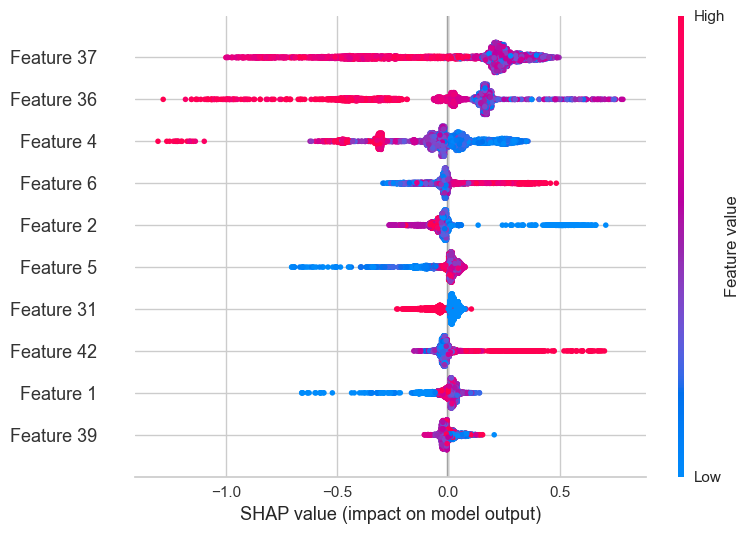

In [ ]:
shap.summary_plot(shap_values_df.to_numpy(), X_shap.to_numpy(), plot_type='dot', show=False, max_display=10)

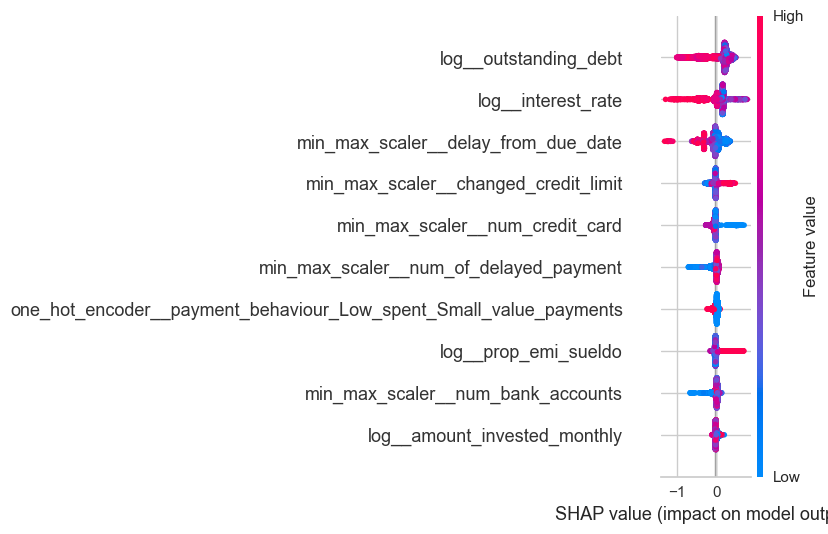

In [ ]:
shap.summary_plot(shap_values_df.to_numpy(), X_shap.to_numpy(), plot_type='dot', show=False, max_display=10, feature_names = feature_names)

Del ``summary_plot`` obtenido se pueden vera las 10 features con mayor importancia de las 43 que entran a los modelos despues de salir del ``ColumnTransformer``. De estas, se puede ver que la que mayor importancia tiene es la feature de deuda pendiente, que se puede ver que se encuentra bien definido que los valores mayores de deuda sin pagar se acumulan en la zona que inclina la balanza de la predicción hacia una de tipo cliente riesgoso, mientras que los valores bajos de esta deuda inclinan la balanza a una predicción de cliente estandar, lo cual es esperable y lógico ya que acumular deudas esta directamente relacionado con el pago o no de estas. Algo similar pasa para la tasa de interes, el retraso promedio de pago, el número de tarjetas de crédito y si esa cuenta tiene pocas compras de poco valor, que mientras mayores son estos valores, mas se inclina como una predicción de cliente riesgoso lo cual a simple vista también se puede ver como comportamientos de cuentas poco confiables ya que no paga a tiempo, una gran cantidad de tarjetas y las pocas compras de bajo valor pueden ser una tecnica para crear distintas cuentas y pedir prestamos desde estas y así otras interpretaciones que es posible de realizar gracias a ete análisis global.

La proporcion de importancias es claramente desbalanceada puesto que  dentro del dataset hay features que servirán más que otras para hacer predicciones.

Seguido a esto se realizó un análisis a 10 casos particulares donde se escogieron 5 que fueran dlientes riesgosos y 5 que fueran clientes comunes, donde se analizará la respuesta entregada por el clasificador y las features que tomaron peso para hacer esta decisión.

In [ ]:
# Índices de las instancias a graficar
instances = [2, 7, 11, 12, 14, 23, 25, 2308, 2312, 2325]
y.reset_index()[y.reset_index().index.isin(instances)].drop(columns='index')

credit_score
2                1
7                1
11               1
12               1
14               1
23               0
25               0
2308             0
2312             0
2325             0

2


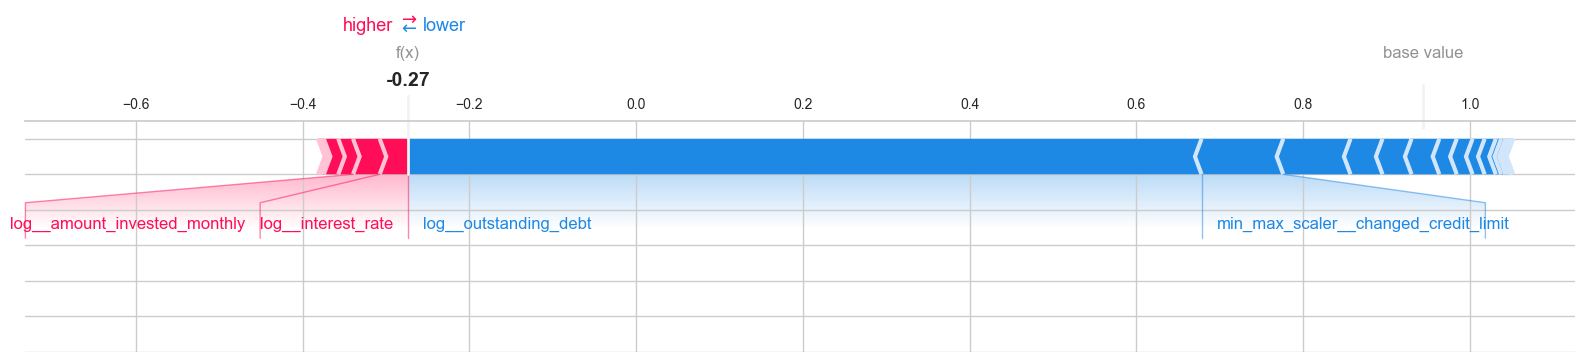

7


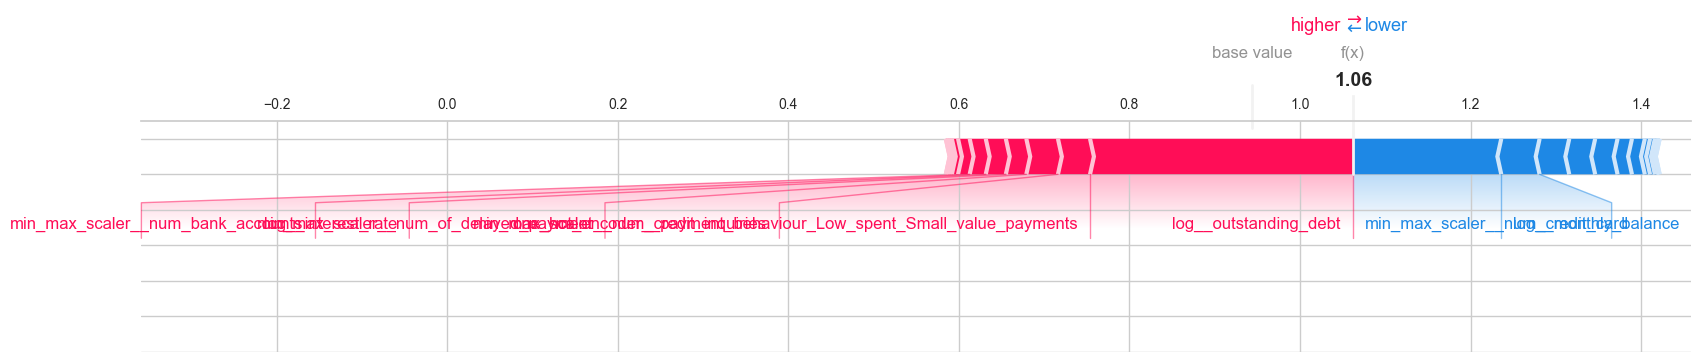

11


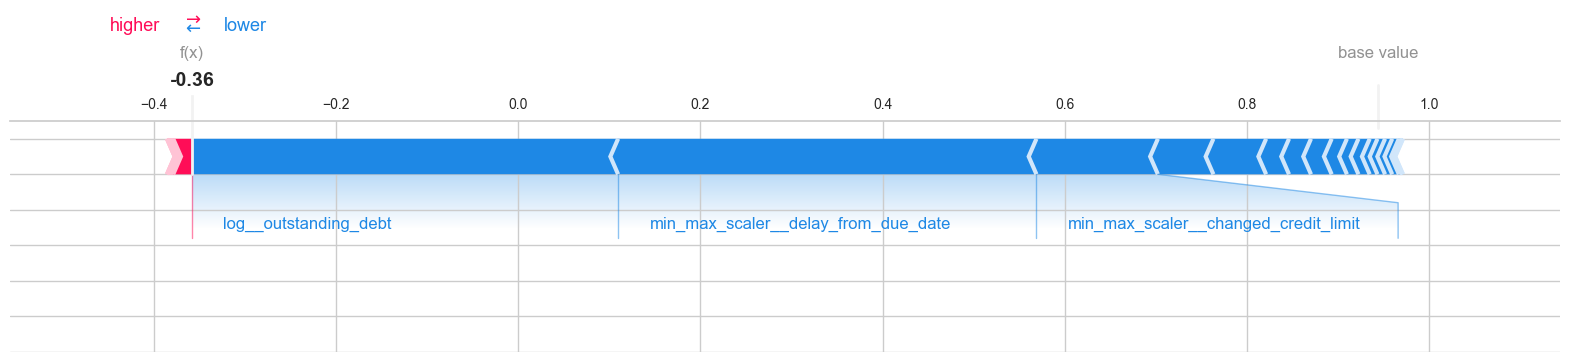

12


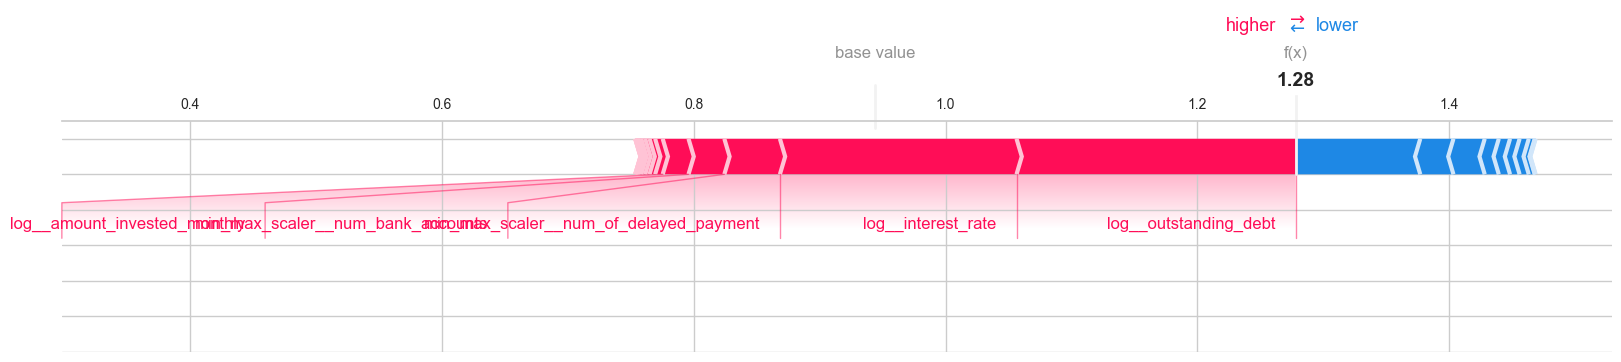

14


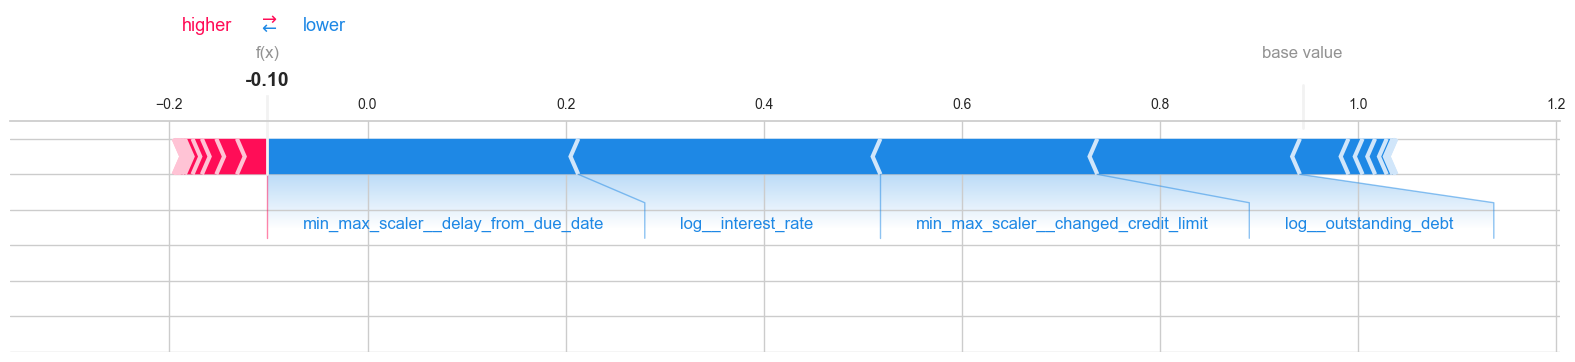

23


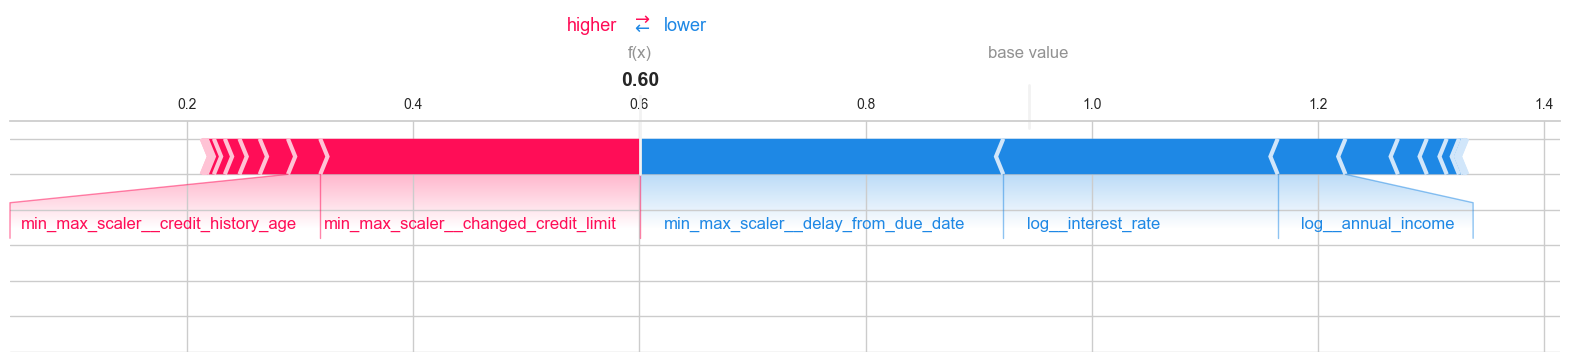

25


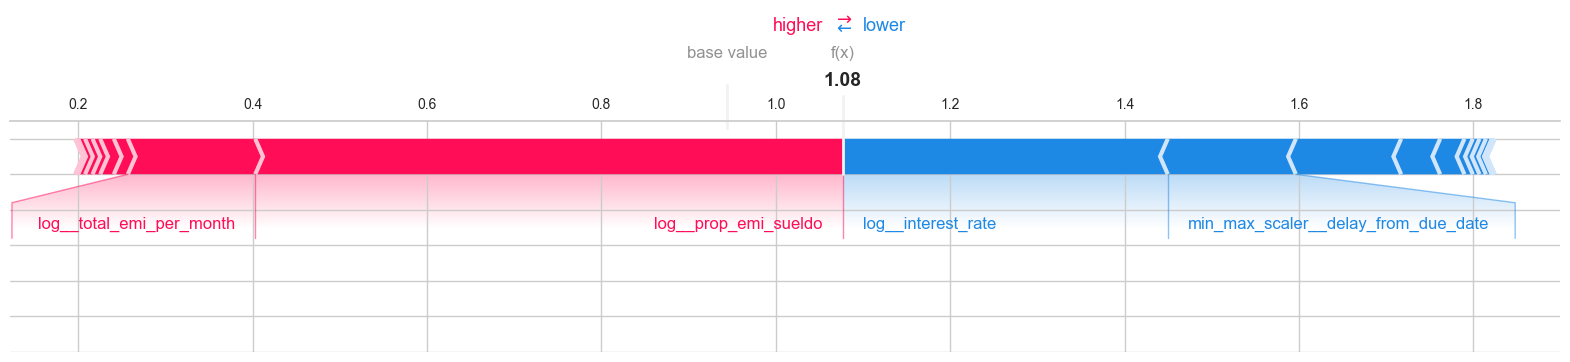

2308


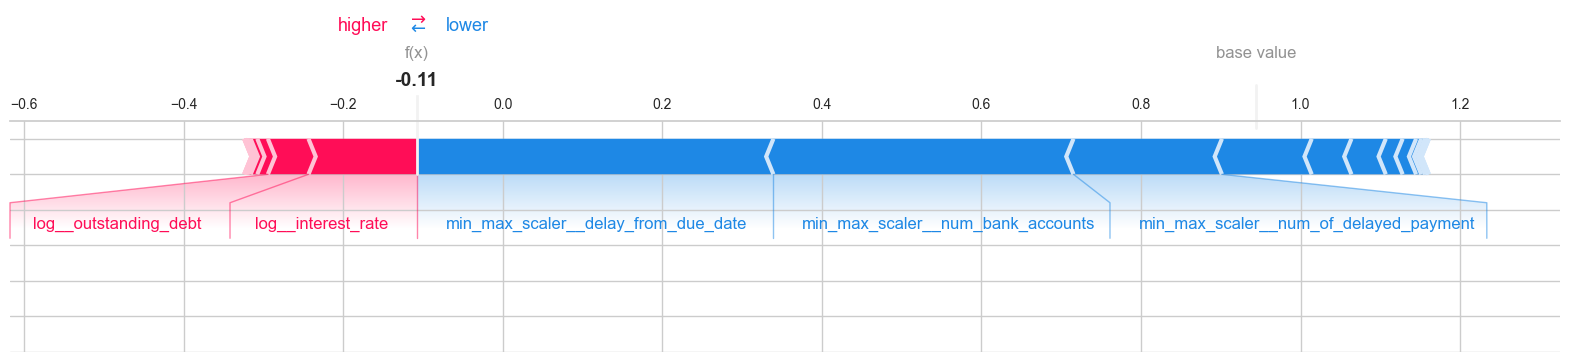

2312


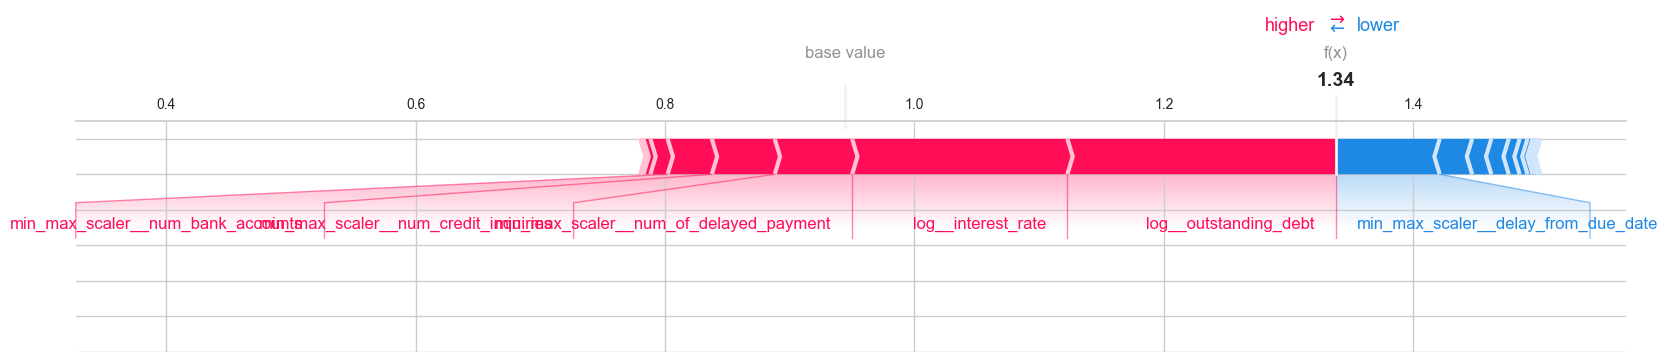

2325


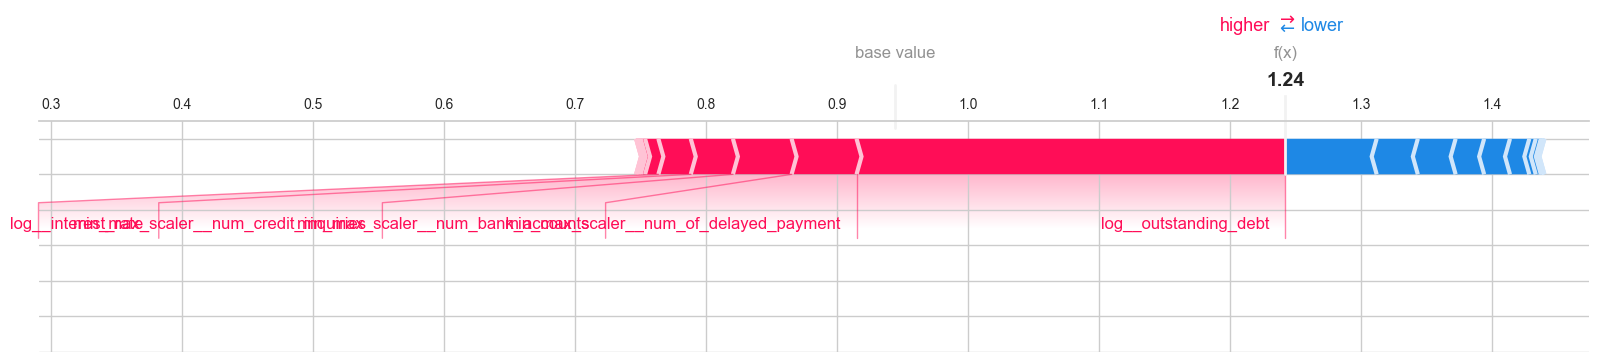

In [ ]:
# Graficar el aporte de las variables para las instancias seleccionadas
for instance in instances:
    print(instance)
    shap.force_plot(
        explainer.expected_value[0],  # Valor esperado (baseline)
        shap_values[0][instance],  # SHAP values para la instancia seleccionada
        feature_names=feature_names,
        matplotlib=True  # Utilizar el backend de matplotlib para graficar
    )

In [ ]:
shap_values_df[shap_values_df.index.isin(instances)]

min_max_scaler__age  min_max_scaler__num_bank_accounts  \
2               -0.013424                          -0.018976   
7                0.007232                           0.018874   
11              -0.012628                          -0.008378   
12               0.004441                           0.028460   
14              -0.000527                          -0.014251   
23               0.009706                           0.000310   
25               0.016030                          -0.006589   
2308            -0.006381                          -0.376205   
2312             0.005545                           0.035466   
2325             0.003365                           0.044789   

      min_max_scaler__num_credit_card  min_max_scaler__num_of_loan  \
2                           -0.038348                     0.000195   
7                           -0.173764                     0.002498   
11                          -0.024136                    -0.000345   
12                          -0.024825                     0.000195   
14                          -0.048996                    -0.000254   
23                          -0.046349                    -0.000254   
25                          -0.027833                    -0.000327   
2308                        -0.112554                     0.000079   
2312                        -0.015390                     0.000195   
2325                        -0.028865                     0.000195   

      min_max_scaler__delay_from_due_date  \
2                               -0.020945   
7                                0.013651   
11                              -0.459307   
12                              -0.026346   
14                              -0.313873   
23                              -0.320846   
25                              -0.146907   
2308                            -0.446668   
2312                            -0.083319   
2325                            -0.031404   

      min_max_scaler__num_of_delayed_payment  \
2                                   0.017734   
7                                   0.024003   
11                                 -0.007847   
12                                  0.044110   
14                                  0.009456   
23                                 -0.025572   
25                                  0.008837   
2308                               -0.186122   
2312                                0.062103   
2325                                0.049570   

      min_max_scaler__changed_credit_limit  \
2                                -0.098010   
7                                -0.026253   
11                               -0.133328   
12                                0.003127   
14                               -0.218999   
23                                0.283031   
25                                0.015609   
2308                             -0.049826   
2312                             -0.013976   
2325                             -0.021750   

      min_max_scaler__num_credit_inquiries  \
2                                -0.005281   
7                                 0.037099   
11                               -0.007325   
12                               -0.008933   
14                               -0.005871   
23                               -0.001651   
25                               -0.001766   
2308                              0.013283   
2312                              0.050449   
2325                              0.032172   

      min_max_scaler__credit_utilization_ratio  \
2                                     0.003233   
7                                    -0.034750   
11                                    0.002208   
12                                   -0.000226   
14                                    0.007737   
23                                    0.006394   
25                                   -0.000004   
2308                                  0.002174   
2312                                  0.0

In [ ]:
X_shap.reset_index()[X_shap.reset_index().index.isin(instances)]

index  min_max_scaler__age  min_max_scaler__num_bank_accounts  \
2         7             0.380952                           0.727273   
7        16             0.142857                           0.545455   
11       21             0.666667                           0.636364   
12       23             0.428571                           0.454545   
14       29             0.571429                           0.909091   
23       73             0.666667                           0.727273   
25       75             0.047619                           0.909091   
2308   5313             0.809524                           0.000000   
2312   5318             0.214286                           0.545455   
2325   5353             0.500000                           0.272727   

      min_max_scaler__num_credit_card  min_max_scaler__num_of_loan  \
2                            0.636364                     0.333333   
7                            0.636364                     0.000000   
11                           0.454545                     0.555556   
12                           0.454545                     0.333333   
14                           0.727273                     0.666667   
23                           0.818182                     0.555556   
25                           0.636364                     0.666667   
2308                         0.636364                     0.444444   
2312                         0.363636                     0.444444   
2325                         0.272727                     0.000000   

      min_max_scaler__delay_from_due_date  \
2                                0.486111   
7                                0.291667   
11                               0.736111   
12                               0.416667   
14                               0.916667   
23                               0.916667   
25                               0.569444   
2308                             0.527778   
2312                             0.458333   
2325                             0.319444   

      min_max_scaler__num_of_delayed_payment  \
2                                   0.500000   
7                                   0.392857   
11                                  0.750000   
12                                  0.678571   
14                                  0.464286   
23                                  0.535714   
25                                  0.607143   
2308                                0.178571   
2312                                0.500000   
2325                                0.571429   

      min_max_scaler__changed_credit_limit  \
2                                 0.567594   
7                                 0.372377   
11                                0.344070   
12                                0.534895   
14                                0.089556   
23                                0.869937   
25                                0.356271   
2308                              0.188873   
2312                              0.261591   
2325                              0.320156   

      min_max_scaler__num_credit_inquiries  \
2                                 0.529412   
7                                 0.235294   
11                                0.352941   
12                                0.647059   
14                                0.470588   
23                                0.588235   
25                                0.588235   
2308                              0.411765   
2312                              0.000000   
2325                              0.176471   

      min_max_scaler__credit_utilization_ratio  ...  \
2                                     0.485746  ...   
7                                     0.267692  ...   
11                                    0.593543  ...   
12                                    0.419762  ...   
14                                    0.522431  ...   
23                                    0.628775  ...   
25                           

De estos 10 casos si la predicción hubiera estado correcto debieran los primeros 5 casos marcar a la izquierda del valor base, mientras que los últimos 5 debieran marcar a la derecha, cosa que no se cumplió en el caso de los indices 7, 12, 23 y 2308, probablemente debido a que las métricas de precisión y recall del modelo entrenado no son las más cercanas al ideal de 1. Sin embargo, se puede ver que en las predicciones locales las features de deuda pendiente y tasa de interes siguen siendo las con más influencia, siendo coherente con el análisis global de cada feature.

Seguido al análisis local se realizan gráficos a las 10 características más relevantes para análizar más a profundidad su impacto sobre la salida

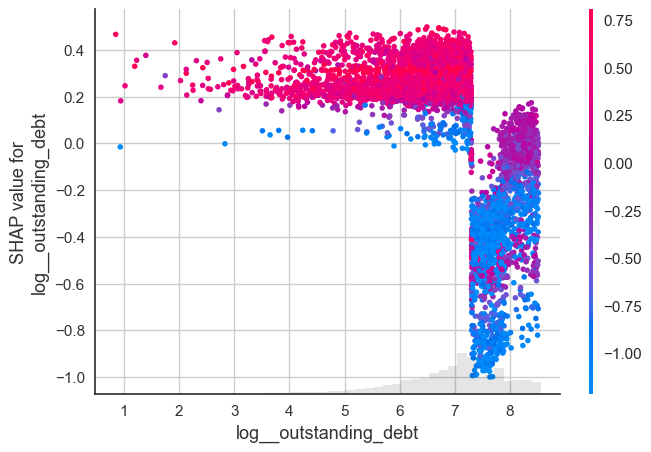

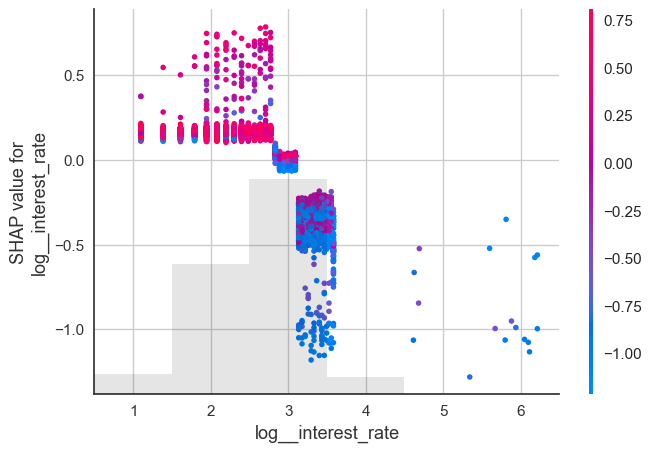

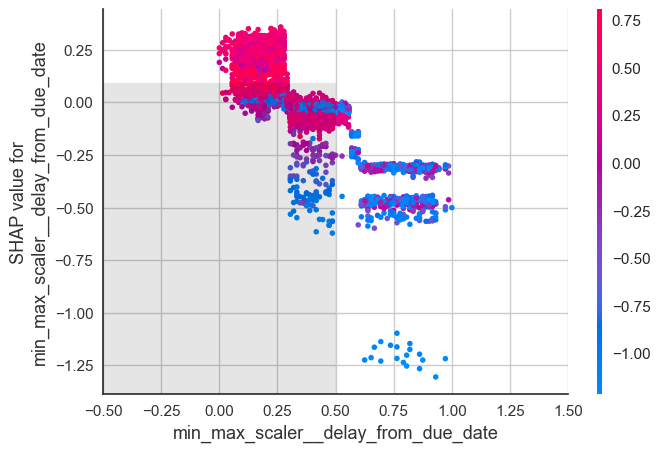

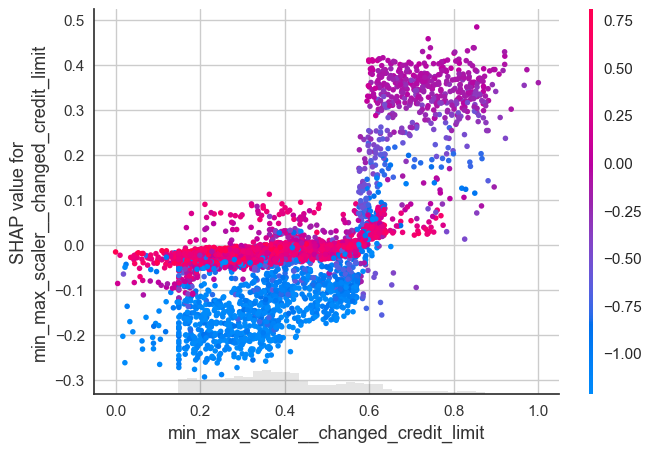

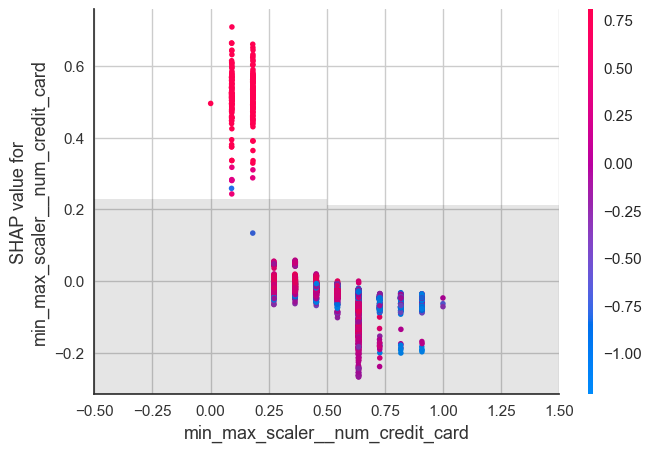

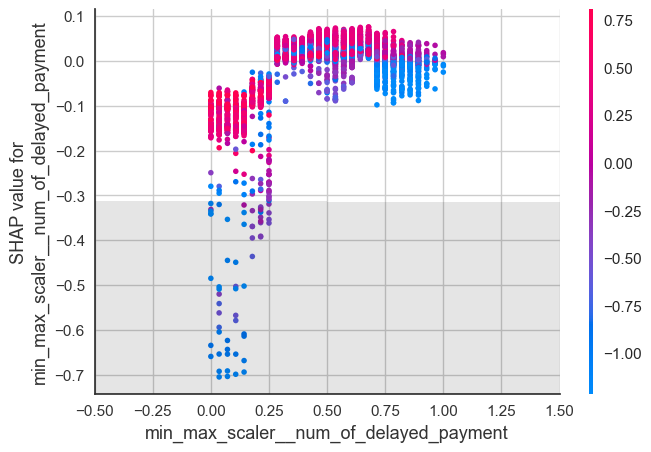

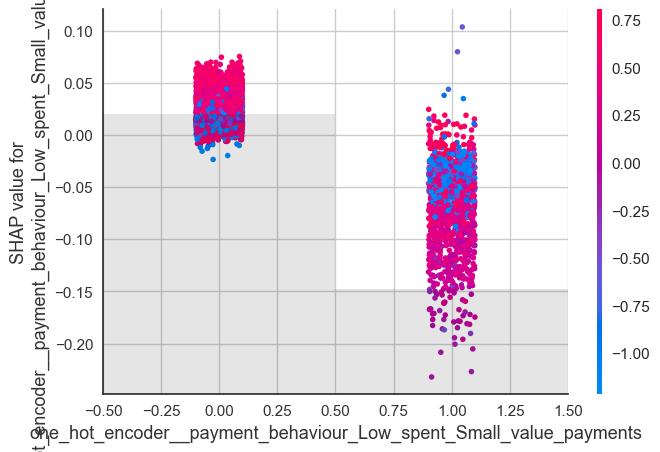

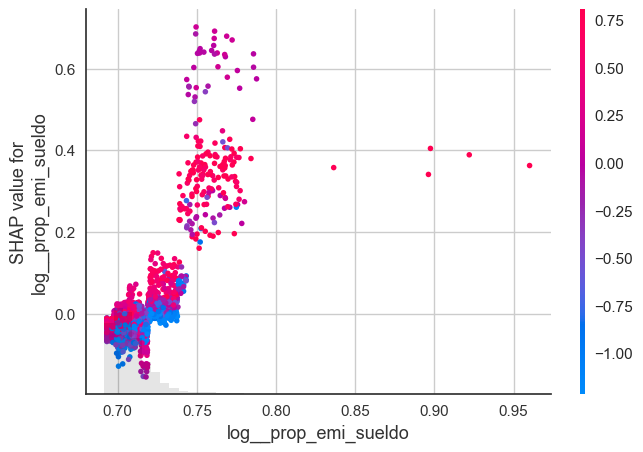

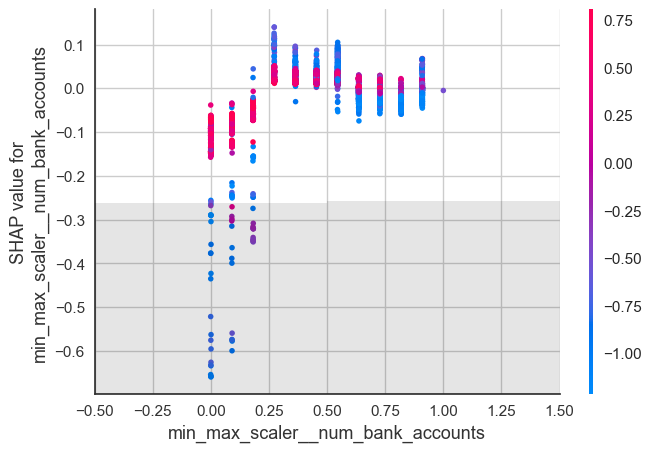

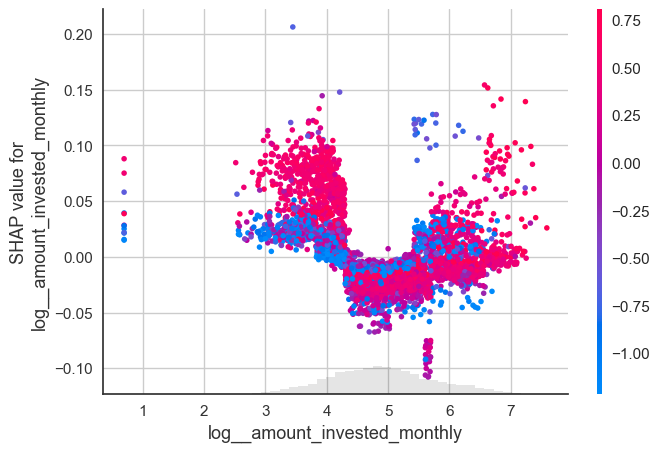

In [ ]:
# Inserte código para generar gráficos de feature vs shap value aquí
# obtenemos los shap values
shap_exp = shap.Explanation(values=shap_values[0], data=X_shap.to_numpy(), feature_names=feature_names)

shap_values_abs = np.mean(np.abs(shap_values[0]), axis=0)

pred_shap = np.sum(shap_exp.values, axis=1) #vector con las sumas de todos los shap values para cada muestra (algo asi como el f(x) de cada )
# Obtenemos los nombres ordenados de mayor a menor
feature_importance_names = feature_names[shap_values_abs.argsort()[::-1]]

for name in feature_importance_names[:10]:
    #shap.dependence_plot(name, shap_exp, X_preprocesed)
    shap.plots.scatter(shap_exp[:, name],
                       color=pred_shap)

De la visualización obtenida se puede obtener tendencias en las caracteristicas más relevantes como en la deuda pendiente, si el valor de la columna es menor a 7 se acumulan la mayoria de los casos que inclinan la balanza para el caso de cliente regular, teniendo una inclinación en el shap value de hasta maximo 0.4, pero en el caso que la deuda aumente , se van acumulando los casos que inclinan la balanza a cliente riesgoso, teniendo shap values de hasta -1, significando que tener deudas altas es mucho más significativo para la prediccion de clientes riesgosos que las deudas bajas para los clientes regulares. Algo similar sucede con los dias de demora de la paga, el número de tarjetas de credito y la tasa de interés. También existen otros casos como el de la feature de pocas compras de bajo precio, que acotan el shap value para el caso que esta columna este en 0, sumando aproximadamente 0,05 en shap value independiente del resto de variables, mientras que si esta variable esta en 1, el shap value asociado tiende a variar más entre 0 y -0,2, esto se puede explicar gracias a que esa feature es juna de tipo one hot, por lo que el hecho que sea 0, debería tener relativamente el mismo impacto a los registros, mientras que el que sea 1 por alguna razon, puede estar entrelazado con alguna otra variable, dando esta mayor varianza en el shap value entregado.

Otro caso interesante es el del cambio del límite de crédito, si bien los que son considerados riesgosos y los que son considerados regulares no poseen una zona fija dentro del eje x, del valor de la variable, ya que hay a la vista misma cantidad de 1 y 0 en este eje, al menos en proporcion, se puede ver que antes de que el valor sea 0,6, en los casos regulares el shap value tiende a ser cercano a 0, mientras que en para los casos riesgosos tiende a ser un valor negativo. Mientras que si el valor del eje x supera los o,6 la predicción se vuelve engorrosa, acumulandose la mayoria de los puntos morados, sin embargo los shap values tienden a inclinar la balanza hacia un cliente regular a pesar de la incertidumbre de la predicción.

Finalmente estan los casos como la inversion mensual, el numero de cuentas bancarias, la proporcion entre EMI y sueldo, la cantidad de demoras que no poseen una tendencia muy clara a la vista, sin embargo se encuentran en la lista debido a que su impacto es significativo para la decisión final.

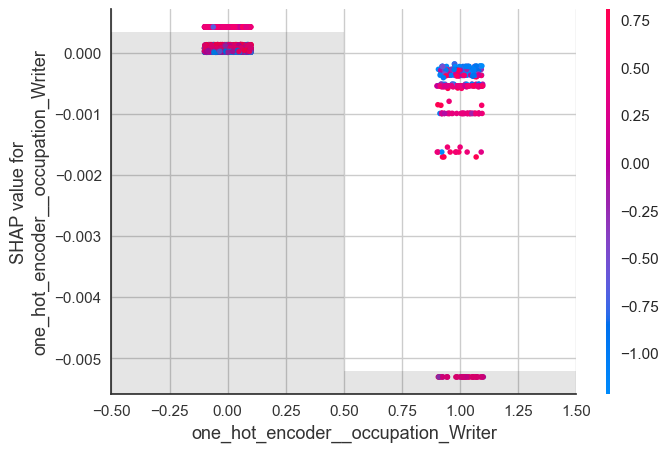

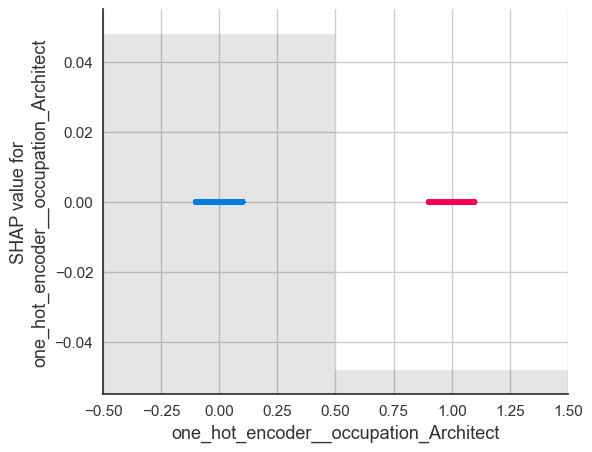

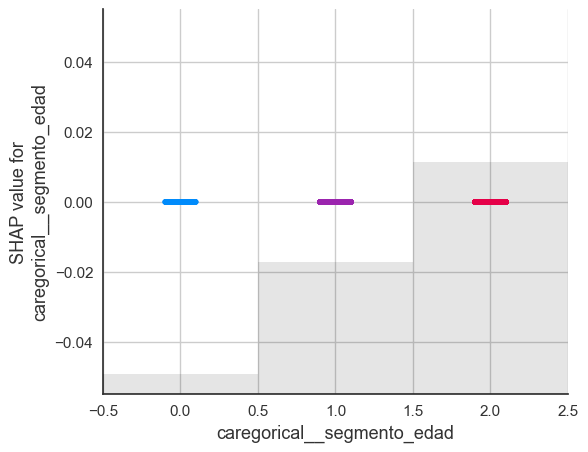

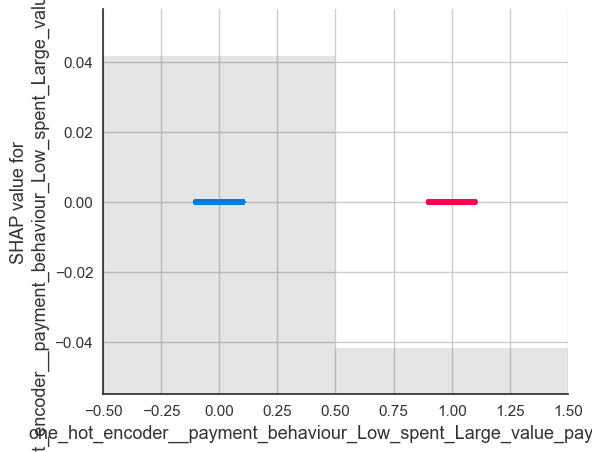

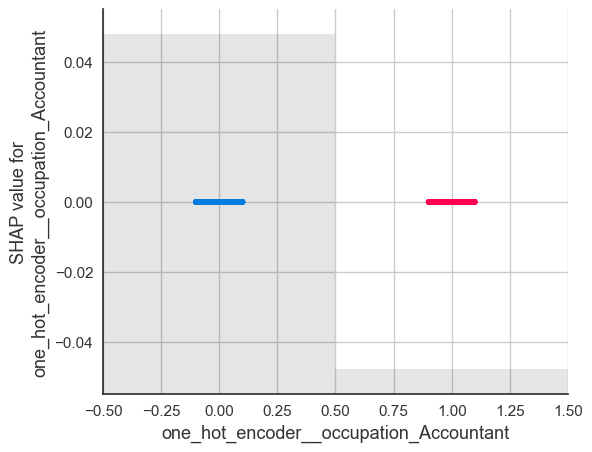

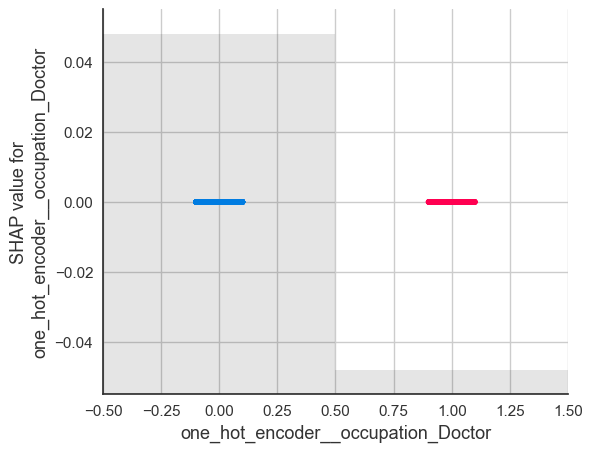

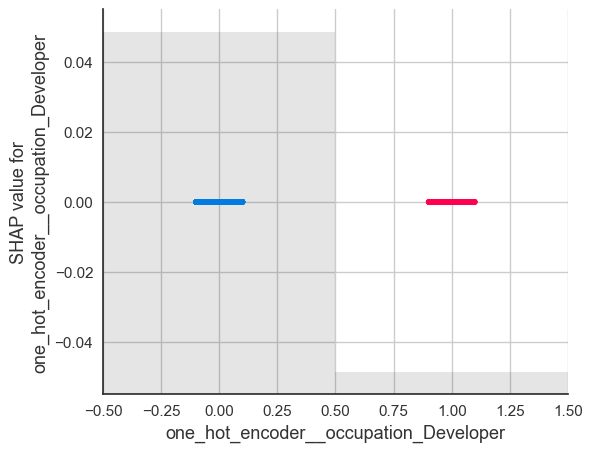

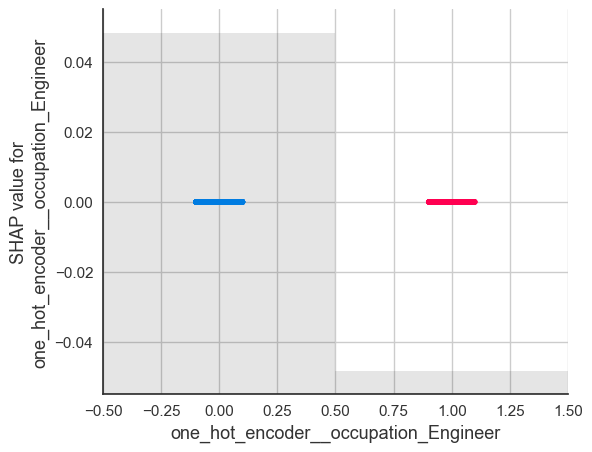

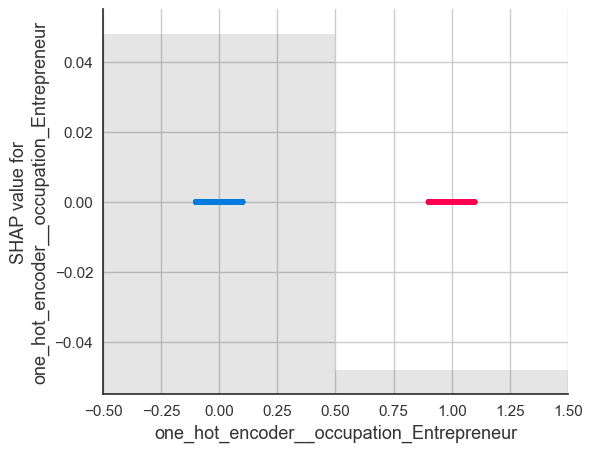

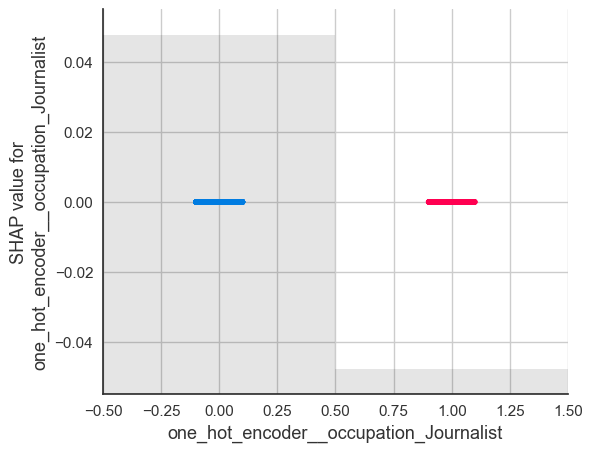

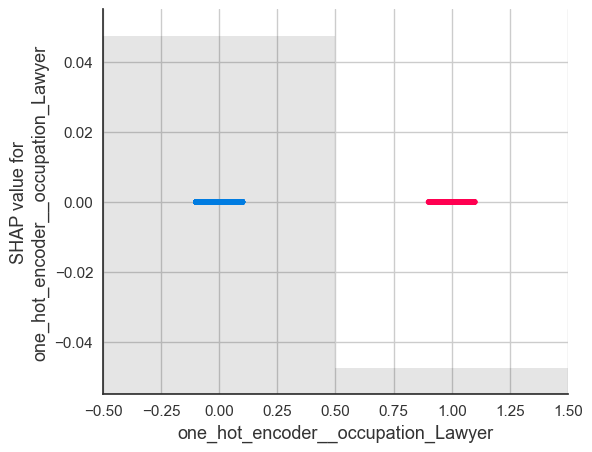

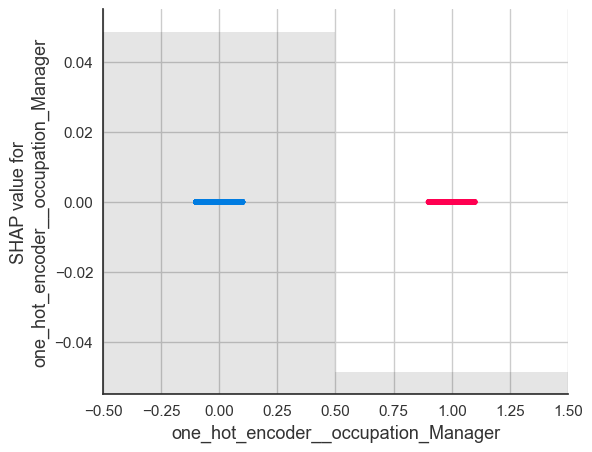

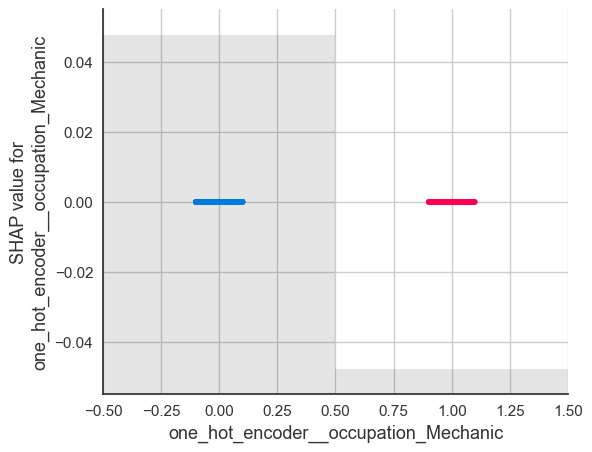

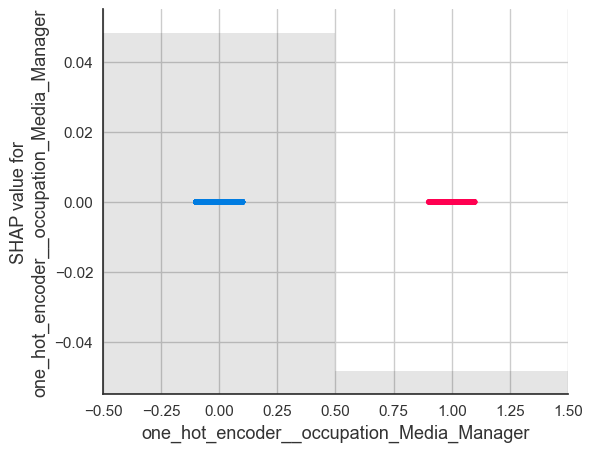

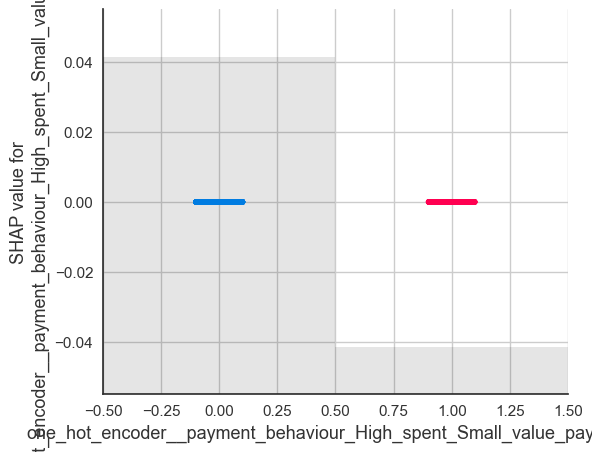

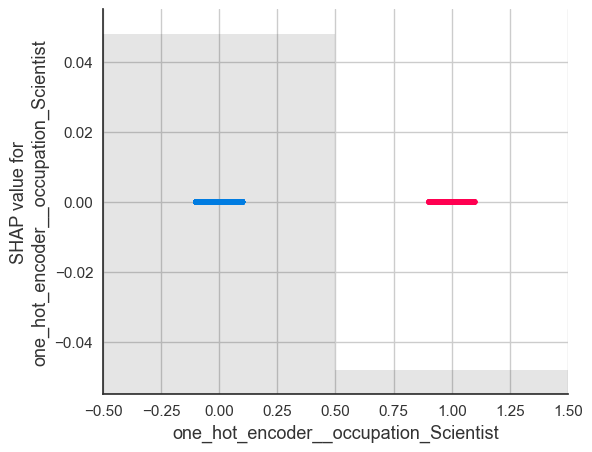

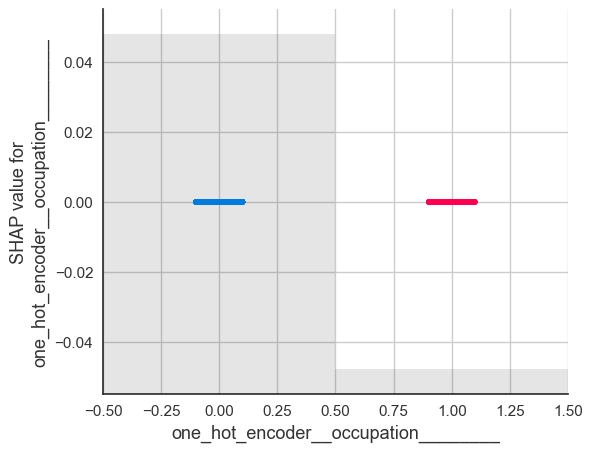

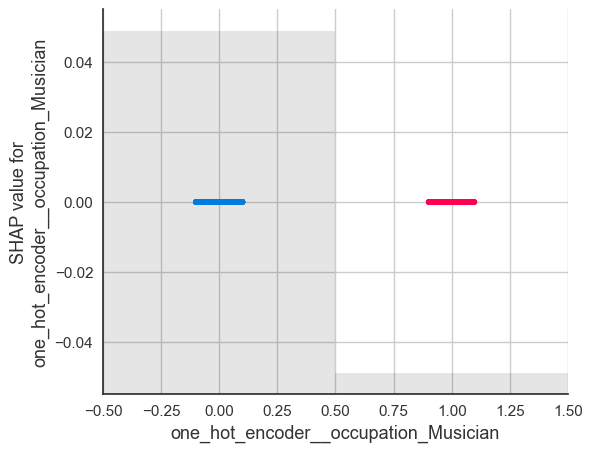

In [ ]:
for name in feature_importance_names[-18:]:
    shap.plots.scatter(shap_exp[:, name],
                       color=pred_shap)

Como se puede ver, las últimas 17 features ordenadas segun importancia no tienen impacto en la respuesta final, reflejandose que el shap value que aportan es 0 independiente del registro. Se puede observar que estas features son en su mayoría ocupaciones, un par de comportamientos de pago, que cabe destacar que uno de estos comportamientos resulto ser de las features más relevantes y la nueva columna agragada del segmento de edad, probablemente porque no se eliminó la columna de edad, haciendo que esta columna solo sea una redundancia de esta otra.

En términos del modelo se puede ver que las features con más impacto son simplemente caracteristicas y comportamientos a nivel bancario, mientras que la feature que hubiera sido más controversial, que era la de ocupación, resulto tener casi nula relevancia, por lo qeu podría eliminarse para así mitigar cualquier sesgo no deseado a nivel ético. Resumiendo, el modelo a primera impresión clasifica los clientes como riesgosos o regulares solo haciendo uso de su historial bancario y no de características personales o intrínsecas de la persona, por lo que no se cae en algún sesgo poco ético.

## 7. Conclusiones

En esta experiencia, nuestro objetivo principal fue predecir si los clientes de un banco eran riesgosos o regulares al solicitar préstamos utilizando técnicas de machine learning aprendidas durante el curso. Durante el proceso, obtuvimos diversos resultados, comenzando con modelos baselines que, al entrenarlos con los datos procesados, arrojaron resultados insatisfactorios. El recall fue la métrica seleccionada para optimizar debido al desbalance en el problema, y observamos valores cercanos a 0.5 para la mayoría de los clasificadores entrenados.

Luego, seleccionamos los dos mejores modelos, un LightGBMClassifier y un RandomForestClassifier, para continuar con su optimización de hiperparámetros. Empleamos diversas técnicas, como GridSearchCV, Optuna y la aplicación de oversampling al conjunto de entrenamiento para aumentar la cantidad de datos de entrenamiento del dataset. Además, exploramos librerías de automl como Pycaret. Los mejores resultados se obtuvieron utilizando Optuna con el dataset original, alcanzando un recall de 0.7 en el LightGBMClassifier, una mejora significativa de 0.2 en comparación con el primer resultado obtenido.

Sin embargo, en términos de la industria, un recall más alto podría ser esperado, ya que actualmente se está otorgando préstamos a aproximadamente el 30% de clientes riesgosos según este modelo. Esto representa un riesgo que muchas empresas no pueden permitirse. Por lo tanto, somos conscientes de que el clasificador aún se puede mejorar y perfeccionar.

El análisis EDA (Exploratory Data Analysis) fue una herramienta valiosa para seleccionar las transformaciones adecuadas para las distribuciones de datos y aplicar limpieza de outliers y valores nulos utilizando estadísticas por columna. Este proceso fue esencial en el trabajo.

Es importante mencionar que las decisiones de limpieza de datos podrían haber sido más óptimas, lo que sugiere la posibilidad de mejorar el conjunto de entrenamiento en este aspecto. Además, otras áreas también podrían haber sido más exhaustivas, como la selección de clasificadores y la dedicación al proceso de obtención de hiperparámetros, junto con su optimización para el recall en la clase 1 en particular.

En general, esta experiencia nos permitió aplicar la mayoría de las herramientas aprendidas en la segunda mitad del curso. Con más tiempo y experiencia, podríamos haber alcanzado resultados con los que estar más satisfechos y considerar que se ha resuelto el problema de manera totalmente exitosa.

La práctica y los resultados obtenidos en este proyecto forman parte de la primera etapa en nuestro camino hacia la mejora en el área de la ciencia de datos. A través de este tipo de proyectos, esperamos progresar y superar problemas de manera más efectiva en futuras ocasiones.




